# Gaussian Regression Colors

This notebook uses gaussian regression to fit CSP light curves and model the evolution of observed color over time. Results are compared to the color evolution of individual models.



In [1]:
import sys
from itertools import combinations

import numpy as np
import sncosmo
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sndata.csp import dr3

sys.path.insert(0, '../')
import sncosmo_models


In [2]:
# Register models and data with sncosmo
sncosmo_models.register_sources(force=True)
dr3.download_module_data()
dr3.register_filters(force=True)

# Load models for different masses
m102 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.02))
m104 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.04))
m14 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.4))
m17 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.7))
salt2 = sncosmo.Model(sncosmo.get_source('salt2', version='2.4'))


## Transmission Filters

We review the CSP filter transmission curves and take note that there are multiple "duplicate" filters where different phsysical filters were used on different telescopes or a filter was broken and subsequently replaced.

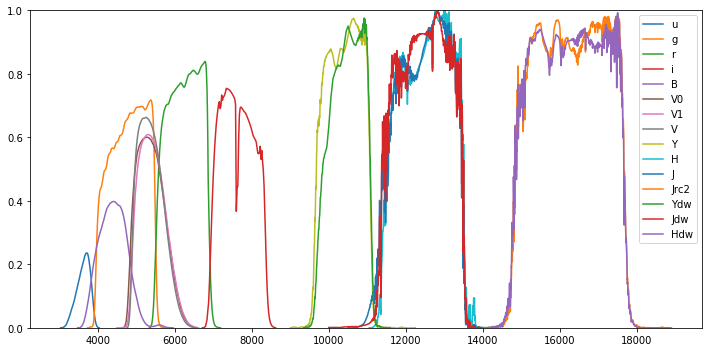

In [3]:
plt.figure(figsize=(10, 5))
for band_name in dr3.band_names:
    band = sncosmo.get_bandpass(band_name)
    band_label = band_name.split('_')[-1]
    plt.plot(band.wave, band.trans, label=band_label)

plt.legend()  
plt.ylim(0, 1)
plt.tight_layout()


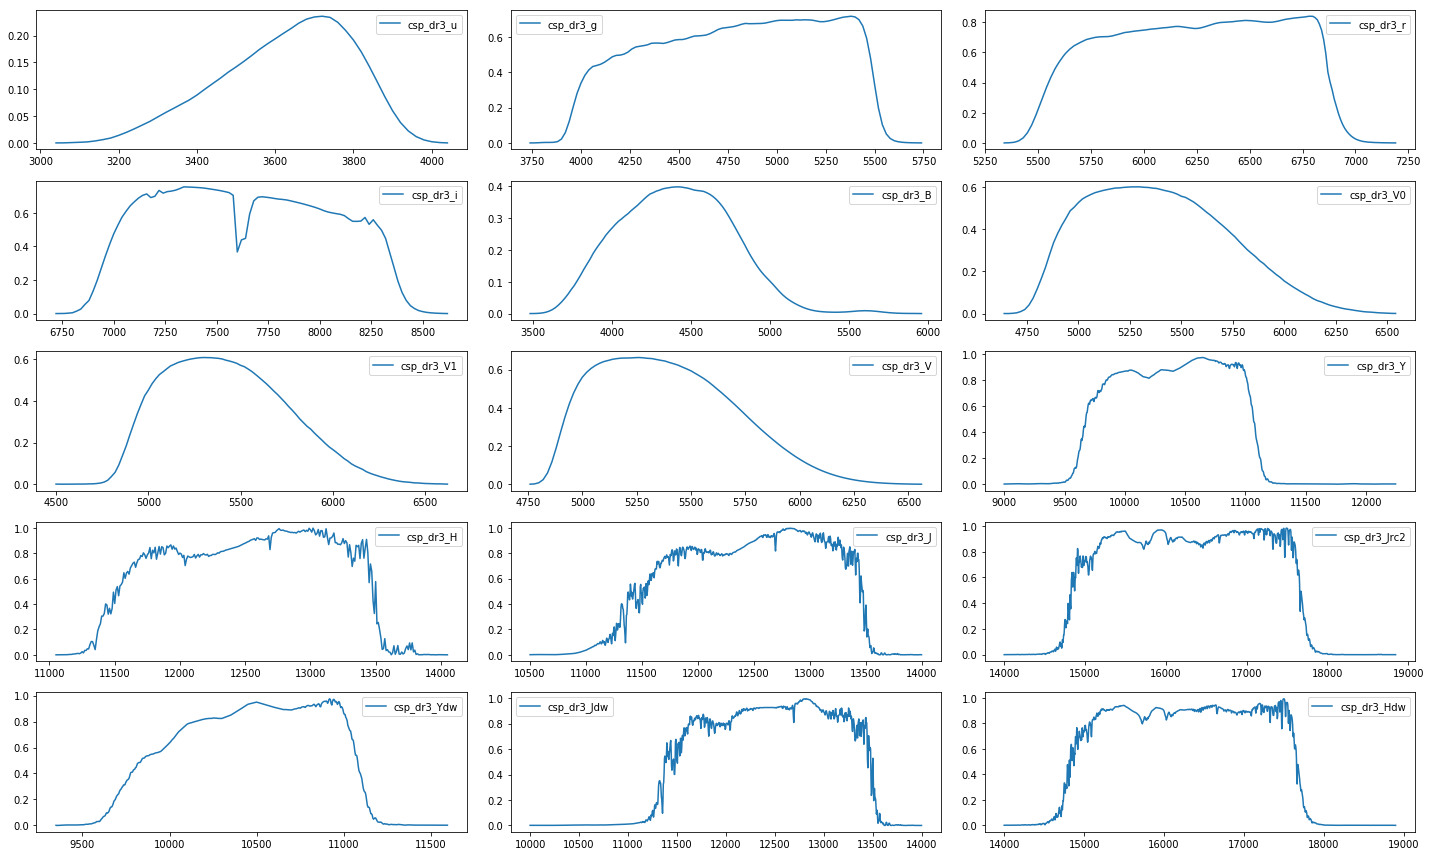

In [4]:
columns = 3
scale_factor = 4

rows = int(np.ceil(len(dr3.band_names) / columns))
fig_shape = (rows, columns)
fig_size = (scale_factor * rows, scale_factor * columns)

fig, axes = plt.subplots(*fig_shape, figsize=fig_size)
for band_name, axis in zip(dr3.band_names, axes.flatten()):
    band = sncosmo.get_bandpass(band_name)
    axis.plot(band.wave, band.trans, label=band_name)
    axis.legend()
    
plt.tight_layout()
    

## CMFGEN Color Evolution

To develope intuition, we compare of CMFGEN color evolution against Salt2.4. We recognize that the color evolution is dependent on the salt2 model parameters, however we only concern ourselves with a fiducial model having the default parameters. We also note that the CMFGEN models do not have any parameters that impact their color evolution.

In [5]:
def subplot_model_colors(model, band_combos, fig, axes):
    """Plot model colors for a given collection of bandpasses
    
    Plots are made on an existing figure
    
    Args:
        model                  (Model): Model to calculate color with
        band_combos (list[tuple[str]]): Band combos to calculate color for
        fig                   (Figure): Use an existing figure
        axes                   (array): Use existing axes
    """
    
    axis_list = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    if len(axis_list) < len(band_combos) - 1:
        raise ValueError('Not enough axes.')
    
    time = np.arange(model.mintime(), model.maxtime())
    t0 = model.source.peakphase('standard::b')
    for (band1, band2), axis in zip(band_combos, axis_list):
        try:
            c = model.color(band1, band2, 'ab', time)
            
        except ValueError as e:
            print(f'{model.source.name} {model.source.version}: {e}')
            pass

        else:
            label = f'{model.source.name} {model.source.version}'
            axis.plot(time - t0, c, label=label)
            
            y_label = f'{band1.split("_")[-1]} - {band2.split("_")[-1]}'
            axis.set_ylabel(y_label)
            axis.set_xlabel('Time')


def plot_model_colors(models, bands):
    """Plot model colors for a given collection of models and bandpasses
    
    Args:
        models (list[Model]): Models to calculate color with
        bands    (list[str]): Bands to calculate color for
    """
    
    band_combos = [(bands[i], bands[i + 1])for i in range(len(bands) - 1)]
    
    columns = 3
    rows = int(np.ceil(len(band_combos) / columns))
    fig_shape = (rows, columns)
    fig_size = (4 * rows, 4 * columns)
    
    fig, axes = plt.subplots(*fig_shape, figsize=fig_size)
    for model in models:
        subplot_model_colors(model, band_combos, fig, axes)
        
    handles, labels = axes.flatten()[0].get_legend_handles_labels()
    fig.legend(handles, labels)
    plt.tight_layout()
    return fig, axes


/anaconda3/envs/cmfgen/lib/python3.7/site-packages/sncosmo/models.py:186: RuntimeWarning: divide by zero encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/anaconda3/envs/cmfgen/lib/python3.7/site-packages/sncosmo/models.py:186: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/anaconda3/envs/cmfgen/lib/python3.7/site-packages/sncosmo/models.py:1528: RuntimeWarning: invalid value encountered in subtract
  self.bandmag(band2, magsys, time))


salt2 2.4: bandpass 'csp_dr3_Y' [9000, .., 12244] outside spectral range [2000, .., 9200]
salt2 2.4: bandpass 'csp_dr3_Y' [9000, .., 12244] outside spectral range [2000, .., 9200]
salt2 2.4: bandpass 'csp_dr3_H' [11050, .., 14050] outside spectral range [2000, .., 9200]


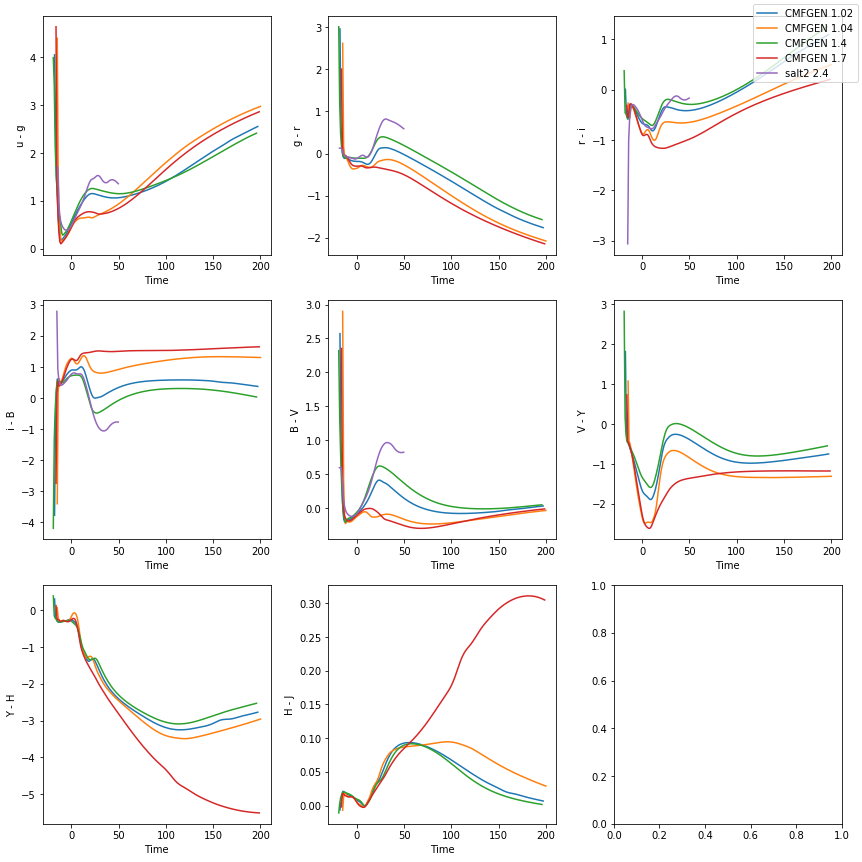

In [6]:
# A set of fiducial band passes.
unique_bands = (
    'csp_dr3_u',
    'csp_dr3_g',
    'csp_dr3_r',
    'csp_dr3_i',
    'csp_dr3_B',
    'csp_dr3_V',
    'csp_dr3_Y',
    'csp_dr3_H',
    'csp_dr3_J'
)

models = [m102, m104, m14, m17]
fig, axes = plot_model_colors(models + [salt2], unique_bands)


We emphasize that there are other color combinations that are not exmplored here but should be since different combinations may provide differnet color degeneracies.

# Gaussian Regression

We use gaussian regression to fit the light curves in each band and determine the color evolution as a function of time.


In [7]:
def get_band_data(data):
    """Return a list of tables for light curves in each band
    
    Args:
        obj_id (str): A supernova's object id
        
    Returns:
        A list of data tables with photometric data for each band
    """

    band_names = set(data['band'])     
    return {band: data[data['band'] == band] for band in band_names}


def regress_band(x, y, y_err, x_pred):
    """Perform gaussian regression on a light curve
    
    Args:
        x     (list[float]): A list of time values
        y     (list[float]): A list of flux or magnitude values
        y_err (list[float]): A list of errors in y
    """

    X = np.atleast_2d(x).T
    
    kernel = RBF()
    gp = GaussianProcessRegressor(kernel=kernel, alpha=y_err)
    gp.fit(X, y)

    X_pred = np.atleast_2d(x_pred).T
    y_pred, sigma = gp.predict(X_pred, return_std=True)
    return y_pred, sigma

    
def regress_data(band_data, x_pred):
    """Perform gaussian regression on all bands for a light curve
    
    Args:
        band_data (list[Table]): A list of data tables with photometric data for each band
        
    Returns:
        A 2-d dictionary of results per band
    """
    
    out_data = dict()
    
    for band_table in band_data.values():
        x = np.array(band_table['time'])
        y = np.array(band_table['mag'])
        y_err = np.array(band_table['mag_err'])
        y_pred, sigma = regress_band(x, y, y_err, x_pred)
        
        data_this = dict()
        data_this['time'] = x
        data_this['flux'] = y
        data_this['flux_err'] = y_err
        data_this['time_pred'] = np.array(x_pred)
        data_this['flux_pred'] = y_pred
        data_this['sigma'] = sigma
        data_this['zp'] = band_table['zp'][0]
        out_data[band_table['band'][0]] = data_this
    
    return out_data


def plot_regression(regression_results):
    """Plot regression results
    
    Args:
        reression_results (dict): Return from ``regress_data``
    """

    columns = 2
    rows = 5
    fig_shape = (rows, columns)
    fig_size = (4 * rows, 8 * columns)

    fig, axes = plt.subplots(*fig_shape, figsize=fig_size)
    for (band_name, r_data), axis in zip(regression_results.items(), axes.flatten()):

        band_label = f'{band_name.split("_")[-1]} band'
        axis.scatter(r_data['time'], r_data['flux'], label=band_label, s=10)        
        axis.errorbar(r_data['time'], r_data['flux'], r_data['flux_err'], linestyle='', markersize=5, label=None)
        axis.plot(r_data['time_pred'], r_data['flux_pred'], label='Prediction', color='black', linestyle='--')
    
        axis.fill_between(
            r_data['time_pred'], 
            r_data['flux_pred'] - 1.9600 * r_data['sigma'], 
            r_data['flux_pred'] + 1.9600 * r_data['sigma'], 
            alpha=.3, 
            label='95% confidence interval',
            color='grey'
        )
        
        axis.legend(loc='upper right')

    plt.tight_layout()
    return fig, axes


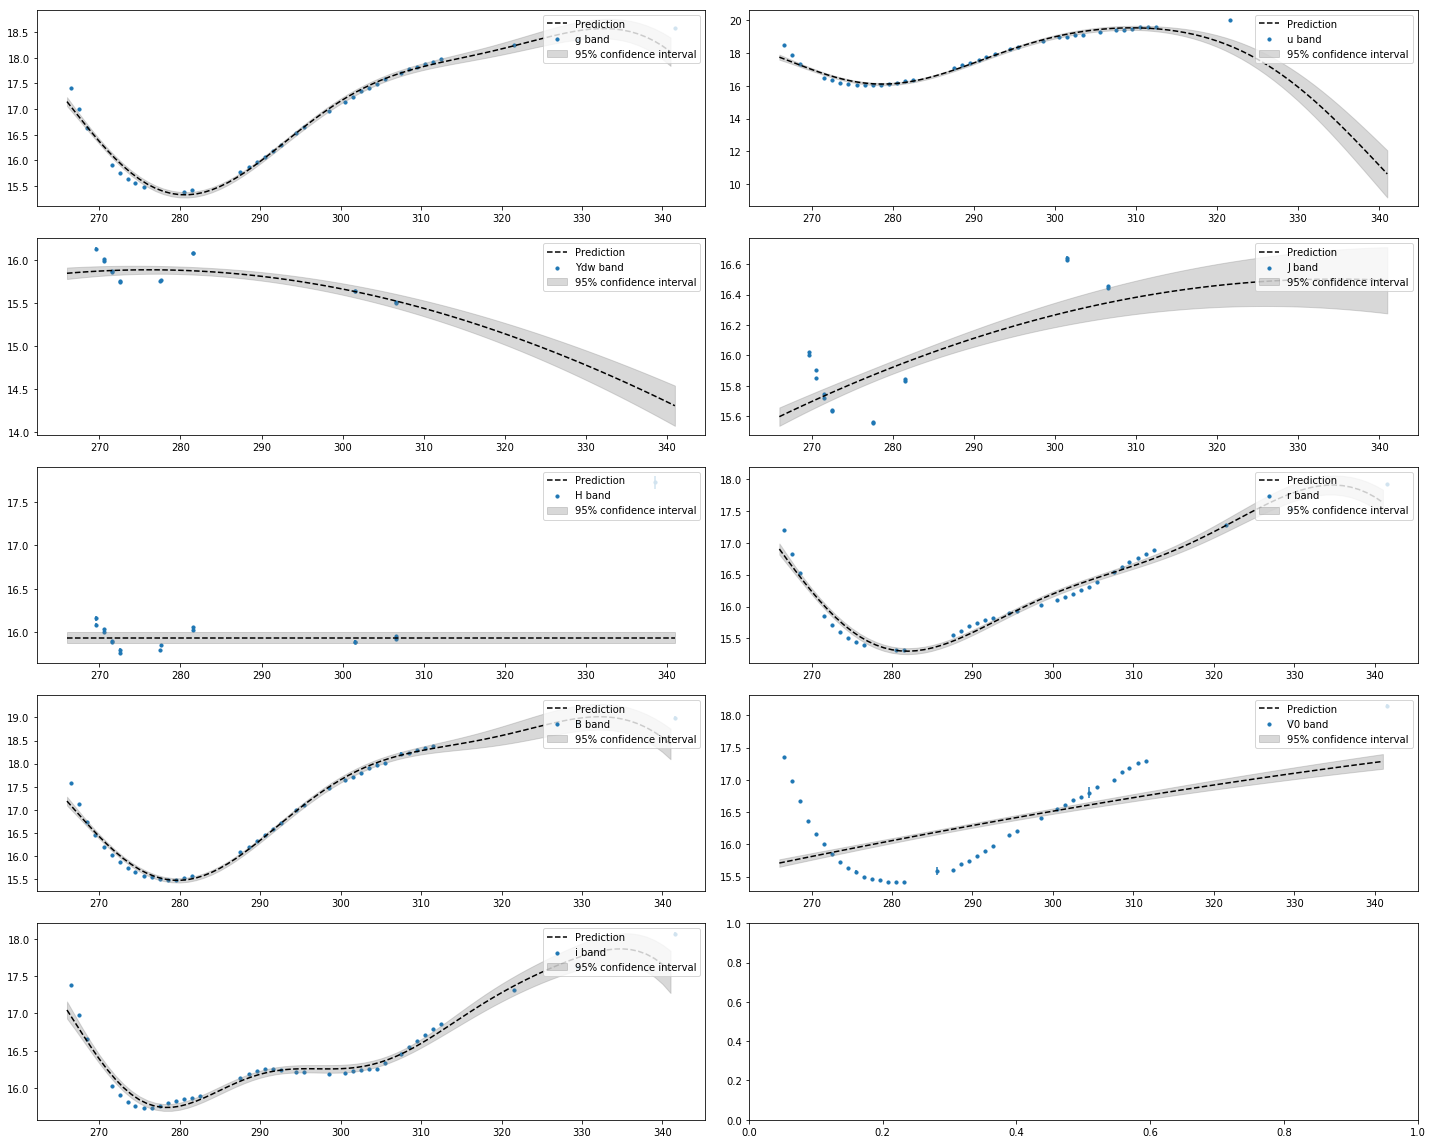

In [8]:
data_table = dr3.get_data_for_id('2004eo', format_sncosmo=True)
band_data = get_band_data(data_table)

x_pred = np.arange(int(min(data_table['time'])), np.ceil(max(data_table['time'])))
regression_results = regress_data(band_data, x_pred)

_ = plot_regression(regression_results)


We note some important takeaways from the above figure:

1. We are not defining the average light curve shape, and so the GPR defaults to an average of zero.
2. We are dealing with the fitting in one dimension, and could instead work in two dimensions by untroducing a covariance between the flux of different bands.
3. Some bands are poorly fit due to under sampling. There is very little we can do about this. However, there are bands that are well sampled that also fail to fit well. This is likly related to the reasons mentioned above.
4. We are fitting in flux space, however it has been indicated by some that fitting in magnitude space can sometimes perform better even though the errors are not gaussian.

## Comparing Gaussian and Modeled Colors

We compare the gaussian fit color evolution against the CMFGEN models. In order to align the time scales of all results, we use the published `t0` (Salt2) value from CSP to shift the gaussian regressions to the correct t = 0 point.

In [9]:
def get_csp_t0(obj_id):
    """Get the t0 value published by CSP for a given object
    
    Args:
        obj_id (str): The object Id value
        
    Return:
        The published time of maximum minus 53000
    """

    params = dr3.load_table(3).to_pandas()
    params.set_index('SN', inplace=True)
    t0 = params.loc[obj_id]['T(Bmax)']
    if np.isnan(t0):
        raise ValueError(f'No published t0 for {obj_id}')
    
    return t0 - 53000  # Convert to CSP standard


In [10]:
def subplot_regression_color(regression_results, band_combos, fig, axes):
    """Plot model colors for a given collection of bandpasses
    
    Plots are made on an existing figure
    
    Args:
        regression_results      (dict): Dictionary of regression results from ``regress_data``
        band_combos (list[tuple[str]]): Band combos to calculate color for
        fig                   (Figure): Use an existing figure
        axes                   (array): Use existing axes
    """
        
    axis_list = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    for (band1, band2), axis in zip(band_combos, axis_list):
        r1 = regression_results[band1]
        r2 = regression_results[band2]
        color = -2.5 * (np.log10(r1['flux_pred'])- np.log10(r2['flux_pred']) )
        axis.plot(r1['time_pred'], color, label=f'Gauss {band1} - {band2}')


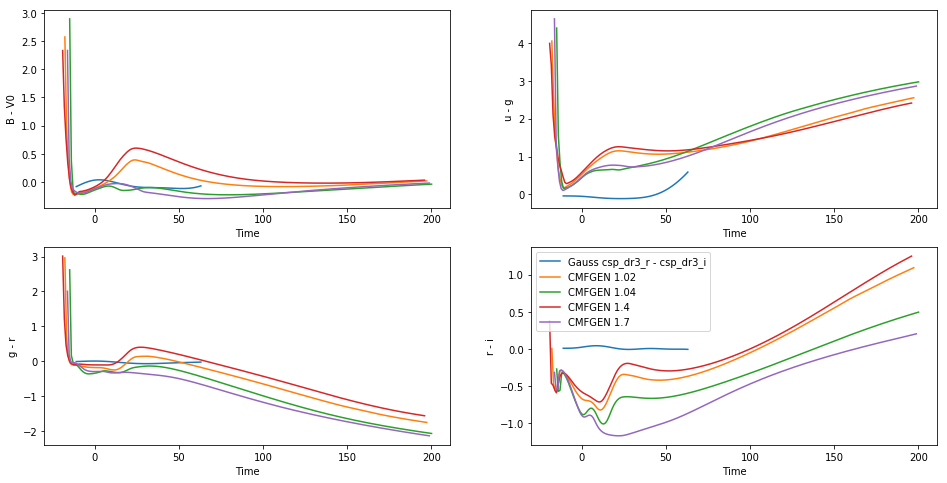

In [11]:
fig_shape = (2, 2)
fig_size = (16, 8)
fig, axes = plt.subplots(*fig_shape, figsize=fig_size)

data_table = dr3.get_data_for_id('2004eo', format_sncosmo=True)
data_table['time'] -= get_csp_t0('2004eo')
band_data = get_band_data(data_table)

time_pred = np.arange(int(min(data_table['time'])), np.ceil(max(data_table['time'])))
regress_results = regress_data(band_data, time_pred)

band_combos = [
    ('csp_dr3_B', 'csp_dr3_V0'), 
    ('csp_dr3_u', 'csp_dr3_g'), 
    ('csp_dr3_g', 'csp_dr3_r'), 
    ('csp_dr3_r', 'csp_dr3_i')]

subplot_regression_color(regress_results, band_combos, fig, axes)

for model in models:
    subplot_model_colors(model, band_combos, fig, axes)

axes[-1][-1].legend()
